In [ ]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch.nn.functional as F
import math

In [ ]:
def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28), nrow=5, show=True):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in an uniform grid.
    '''
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=nrow)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    if show:
        plt.show()

# Generator and Noise

In [ ]:
class Generator(nn.Module):
    '''
    Generator Class
    Values:
        input_dim: the dimension of the input vector, a scalar
        im_chan: the number of channels of the output image, a scalar (MNIST is black-and-white, so 1 channel is your default)
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, input_dim=10, im_chan=1, hidden_dim=64):
        super(Generator, self).__init__()
        self.input_dim = input_dim
        self.gen = nn.Sequential(
            self.make_gen_block(input_dim, hidden_dim * 4, kernel_size=3, stride=2,), # (m, hidden_dim * 4, 3, 3)
            self.make_gen_block(hidden_dim * 4, hidden_dim * 2, kernel_size=4, stride=1), # (m, hidden_dim * 2, 6, 6)
            self.make_gen_block(hidden_dim * 2, hidden_dim, kernel_size=3, stride=2,), # (m, hidden_dim * 2, 13, 13)
            self.make_gen_block(hidden_dim, im_chan, kernel_size=4, final_layer=True), # (m, 1, 28, 28)
        )

    def make_gen_block(self, input_channels, output_channels, kernel_size=3, stride=2, final_layer=False):
        '''
        Function to return a sequence of operations corresponding to a generator block of DCGAN;
        a transposed convolution, a batchnorm (except in the final layer), and an activation.
        Parameters:
            input_channels: how many channels the input feature representation has
            output_channels: how many channels the output feature representation should have
            kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
            stride: the stride of the convolution
            final_layer: a boolean, true if it is the final layer and false otherwise (affects activation and batchnorm)
        '''
        if not final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.ReLU(inplace=True),
            )
        else:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.Tanh(),
            )

    def forward(self, noise):
        '''
        Function for completing a forward pass of the generator: Given a noise tensor(n_samples, input_dim), 
        '''
        x = noise.view(len(noise), self.input_dim, 1, 1) # (m, z_dim, 1, 1)
        return self.gen(x) # (m, 1, 28, 28)

def get_noise(n_samples, input_dim, device='cpu'):
    '''
    Function for creating noise vectors: Given the dimensions (n_samples, input_dim)
    creates a tensor of that shape filled with random numbers from the normal distribution.
    '''
    return torch.randn(n_samples, input_dim, device=device) # (m, z_dim)

# Discriminator

In [ ]:
class Discriminator(nn.Module):
    '''
    Discriminator Class
    Values:
      im_chan: the number of channels of the output image, a scalar (MNIST is black-and-white, so 1 channel is your default)
      hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, im_chan=1, hidden_dim=64):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            self.make_disc_block(im_chan, hidden_dim), # (m, hidden_dim, 13, 13)
            self.make_disc_block(hidden_dim, hidden_dim * 2), # (m, hidden_dim * 2, 5, 5)
            self.make_disc_block(hidden_dim * 2, 1, final_layer=True), # (m, 1, 1, 1)
        )

    def make_disc_block(self, input_channels, output_channels, kernel_size=4, stride=2, final_layer=False):
        '''
        Function to return a sequence of operations corresponding to a discriminator block of the DCGAN; 
        a convolution, a batchnorm (except in the final layer), and an activation (except in the final layer).
        Parameters:
            input_channels: how many channels the input feature representation has
            output_channels: how many channels the output feature representation should have
            kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
            stride: the stride of the convolution
            final_layer: a boolean, true if it is the final layer and false otherwise 
                      (affects activation and batchnorm)
        '''
        if not final_layer:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.LeakyReLU(0.2, inplace=True),
            )
        else:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
            )

    def forward(self, image):
        '''
        Function for completing a forward pass of the discriminator: Given an image tensor, 
        returns a 1-dimension tensor representing fake/real.
        Parameters:
            image: a flattened image tensor with dimension (im_chan)
        '''
        disc_pred = self.disc(image) # (m, 1, 1, 1)
        return disc_pred.view(len(disc_pred), -1) # (m, 1)

# Class Input

In conditional GANs, the input vector for the generator will also need to include the class information. The class is represented using a one-hot encoded vector where its length is the number of classes and each index represents a class. The vector is all 0's and a 1 on the chosen class. Given the labels of multiple images (e.g. from a batch) and number of classes, please create one-hot vectors for each label. There is a class within the PyTorch functional library that can help you.


In [ ]:
def get_one_hot_labels(labels, n_classes):
    '''
    Function for creating one-hot vectors for the labels, returns a tensor of shape (?, num_classes).
    Parameters:
        labels: tensor of labels from the dataloader, size (?)
        n_classes: the total number of classes in the dataset, an integer scalar
    '''
    return F.one_hot(labels, n_classes) # (m , n_classes)

def combine_vectors(x, y):
    '''
    Function for combining two vectors with shapes (n_samples, ?) and (n_samples, ?).
    Parameters:
      x: (n_samples, ?) the first vector. 
      y: (n_samples, ?) the second vector.
    '''
    combined = torch.cat((x.float(), y.float()), 1) # (m , x_dim + y_dim)
    return combined

In [ ]:
a = get_one_hot_labels(labels=torch.Tensor([[0, 2, 1]]).long(), n_classes=3).tolist()
b = combine_vectors(torch.tensor([[1, 2], [3, 4]]), torch.tensor([[5, 6], [7, 8]]))
print(a)
print(b)

[[[1, 0, 0], [0, 0, 1], [0, 1, 0]]]
tensor([[1., 2., 5., 6.],
        [3., 4., 7., 8.]])


# Model Training

In [ ]:
# 0 to 9 class
mnist_shape = (1, 28, 28)
n_classes = 10

# parameter
criterion = nn.BCEWithLogitsLoss()
n_epochs = 200
z_dim = 64
display_step = 500
batch_size = 128
lr = 0.0002
device = 'cuda'

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

dataloader = DataLoader(
    MNIST('.', download=True, transform=transform),
    batch_size=batch_size,
    shuffle=True)

In [ ]:
def get_input_dimensions(z_dim, mnist_shape, n_classes):
    '''
    Function for getting the size of the conditional input dimensions 
    from z_dim, the image shape, and number of classes.
    Parameters:
        z_dim: the dimension of the noise vector, a scalar
        mnist_shape: the shape of each MNIST image as (C, W, H), which is (1, 28, 28)
        n_classes: the total number of classes in the dataset, an integer scalar (10 for MNIST)
    Returns: 
        generator_input_dim: the input dimensionality of the conditional generator, which takes the noise and class vectors
        discriminator_im_chan: the number of input channels to the discriminator (e.g. C x 28 x 28 for MNIST)
    '''
    generator_input_dim = z_dim + n_classes
    discriminator_im_chan = mnist_shape[0] + n_classes
    return generator_input_dim, discriminator_im_chan

In [ ]:
gen_dim, disc_dim = get_input_dimensions(10, (1, 28, 28), 9)
print(gen_dim, disc_dim)

19 10


In [ ]:
generator_input_dim, discriminator_im_chan = get_input_dimensions(z_dim, mnist_shape, n_classes)

gen = Generator(input_dim=generator_input_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr)
disc = Discriminator(im_chan=discriminator_im_chan).to(device)
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)

def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02) # mean =0, std=0.02
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)

gen = gen.apply(weights_init)
disc = disc.apply(weights_init)

In [ ]:
cur_step = 0
generator_losses = []
discriminator_losses = []

noise_and_labels = False
fake = False
fake_image_and_labels = False
real_image_and_labels = False
disc_fake_pred = False
disc_real_pred = False

for epoch in range(n_epochs):
    # Dataloader returns the batches and the labels
    for real, labels in tqdm(dataloader):

        cur_batch_size = len(real) #(m)
        real = real.to(device)
        one_hot_labels = get_one_hot_labels(labels.to(device), n_classes) # (m, 10)
        image_one_hot_labels = one_hot_labels[:, :, None, None] # (m, 10, 1, 1)
        image_one_hot_labels = image_one_hot_labels.repeat(1, 1, mnist_shape[1], mnist_shape[2]) # (m, 10, 28, 28)

        ############################
        ### Update discriminator ###
        ############################

        # Zero out the discriminator gradients
        disc_opt.zero_grad()
        # Get noise corresponding to the current batch_size 
        fake_noise = get_noise(cur_batch_size, z_dim, device=device) # (m, 64)
        
        # Combine the noise vectors and the one-hot labels for the generator
        noise_and_labels = combine_vectors(fake_noise, one_hot_labels) # (m, 74)
        # Generate the conditioned fake images
        fake = gen(noise_and_labels) # (m, 1, 28, 28)

        # Combine the fake images with image_one_hot_labels
        fake_image_and_labels = combine_vectors(fake, image_one_hot_labels) # (m, 11, 28, 28)
         # Get the discriminator's prediction on the fakes as disc_fake_pred
        disc_fake_pred = disc(fake_image_and_labels.detach()) # (128, 1)

        # Combine the real images with image_one_hot_labels
        real_image_and_labels = combine_vectors(real, image_one_hot_labels) # (128, 11, 28, 28)
        # Get the discriminator's prediction on the reals as disc_real_pred
        disc_real_pred = disc(real_image_and_labels) # (128, 1)
        
        # loss
        disc_fake_loss = criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred)) 
        disc_real_loss = criterion(disc_real_pred, torch.ones_like(disc_real_pred))
        disc_loss = (disc_fake_loss + disc_real_loss) / 2 # ()
        disc_loss.backward(retain_graph=True)
        disc_opt.step() 

        # Keep track of the average discriminator loss
        discriminator_losses += [disc_loss.item()]

        ############################
        ### Update generator ###
        ############################

        # Zero out the generator gradients
        gen_opt.zero_grad()

        fake_image_and_labels = combine_vectors(fake, image_one_hot_labels) # (128, 11, 28, 28)
        disc_fake_pred = disc(fake_image_and_labels) # (128, 1)
        gen_loss = criterion(disc_fake_pred, torch.ones_like(disc_fake_pred)) #()
        gen_loss.backward()
        gen_opt.step()

        # Keep track of the generator losses
        generator_losses += [gen_loss.item()]

        if cur_step % display_step == 0 and cur_step > 0:
            gen_mean = sum(generator_losses[-display_step:]) / display_step
            disc_mean = sum(discriminator_losses[-display_step:]) / display_step
            print(f"Step {cur_step}: Generator loss: {gen_mean}, discriminator loss: {disc_mean}")
            show_tensor_images(fake)
            show_tensor_images(real)
            step_bins = 20
            x_axis = sorted([i * step_bins for i in range(len(generator_losses) // step_bins)] * step_bins)
            num_examples = (len(generator_losses) // step_bins) * step_bins
            plt.plot(
                range(num_examples // step_bins), 
                torch.Tensor(generator_losses[:num_examples]).view(-1, step_bins).mean(1),
                label="Generator Loss"
            )
            plt.plot(
                range(num_examples // step_bins), 
                torch.Tensor(discriminator_losses[:num_examples]).view(-1, step_bins).mean(1),
                label="Discriminator Loss"
            )
            plt.legend()
            plt.show()
        elif cur_step == 0:
            print("Congratulations! If you've gotten here, it's working. Please let this train until you're happy with how the generated numbers look, and then go on to the exploration!")
        cur_step += 1

# Exploration

In [ ]:
# Before you explore, you should put the generator
# generator in eval mode, both in general and so that batch norm doesn't cause issues and is using its eval statistics
gen = gen.eval()

## Changing Class Vector
You can generate some numbers with your new model! You can add interpolation as well to make it more interesting.

So starting from a image, you will produce intermediate images that look more and more like the ending image until you get to the final image. Your're basically morphing one image into another. You can choose what these two images will be using your conditional GAN.

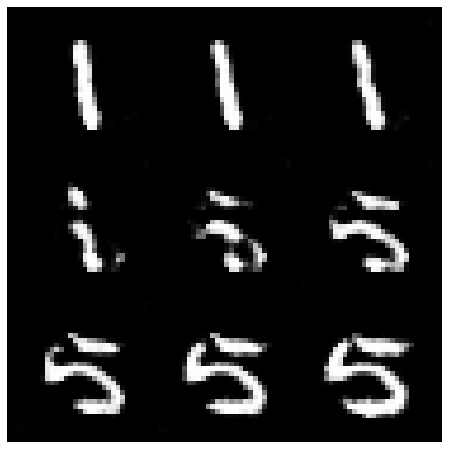

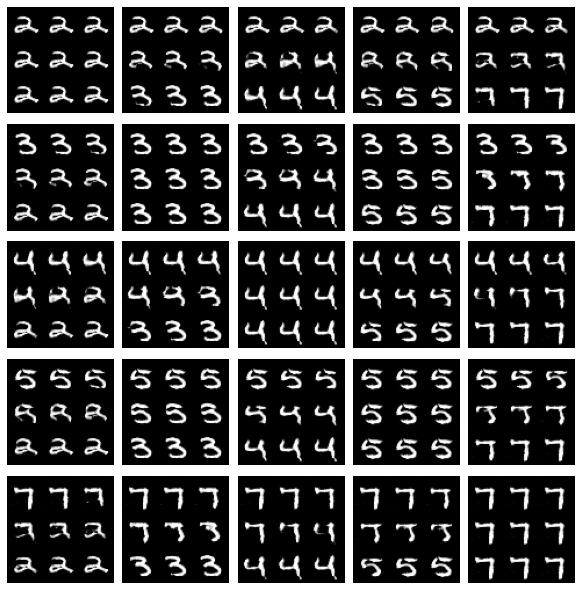

In [ ]:
# Choose the interpolation: how many intermediate images you want from first number to second number
n_interpolation = 9
interpolation_noise = get_noise(1, z_dim, device=device).repeat(n_interpolation, 1) # (n_interpolation, 64)

def interpolate_class(first_number, second_number):
    first_label = get_one_hot_labels(torch.Tensor([first_number]).long(), n_classes) # (1, n_class)
    second_label = get_one_hot_labels(torch.Tensor([second_number]).long(), n_classes) # (1, n_class)

    # Calculate the interpolation vector between the two labels
    percent_second_label = torch.linspace(0, 1, n_interpolation)[:, None] # (n_interpolation, 1)
    interpolation_labels = first_label * (1 - percent_second_label) + second_label * percent_second_label

    # Combine the noise and the labels
    noise_and_labels = combine_vectors(interpolation_noise, interpolation_labels.to(device))
    fake = gen(noise_and_labels)
    show_tensor_images(fake, num_images=n_interpolation, nrow=int(math.sqrt(n_interpolation)), show=False)

# Choose the start and end digit
start_plot_number = 1 
end_plot_number = 5

plt.figure(figsize=(8, 8))
interpolate_class(start_plot_number, end_plot_number)
_ = plt.axis('off')

# num = 5
# noise = get_noise(1, z_dim, device=device)
# label = get_one_hot_labels(torch.Tensor([num]).long(), n_classes)
# noise_and_labels = combine_vectors(noise, label.to(device))
# fake = gen(noise_and_labels)
# show_tensor_images(fake)

# Changing the Noise Vector
Now, what happens if you hold the class constant, but instead you change the noise vector? You can also interpolate the noise vector and generate an image at each step.

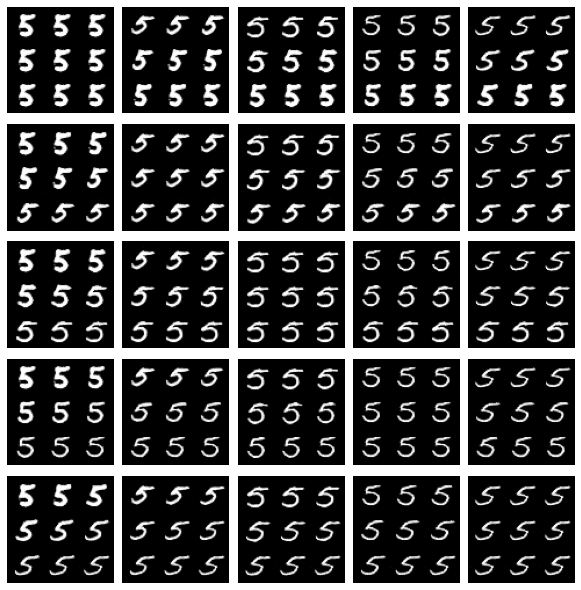

In [ ]:
# How many intermediate images you want
n_interpolation = 9  

# interpolating the labels multiple time
interpolation_label = get_one_hot_labels(torch.Tensor([5]).long(), n_classes).repeat(n_interpolation, 1).float() # (9, 10)

def interpolate_noise(first_noise, second_noise):
    # interpolating the noise instead of the labels
    percent_first_noise = torch.linspace(0, 1, n_interpolation)[:, None].to(device)
    interpolation_noise = first_noise * percent_first_noise + second_noise * (1 - percent_first_noise)

    # Combine the noise and the labels again
    noise_and_labels = combine_vectors(interpolation_noise, interpolation_label.to(device))
    fake = gen(noise_and_labels)
    show_tensor_images(fake, num_images=n_interpolation, nrow=int(math.sqrt(n_interpolation)), show=False)

# Choose the number of noise examples in the grid
n_noise = 5 
plot_noises = [get_noise(1, z_dim, device=device) for i in range(n_noise)]
plt.figure(figsize=(8, 8))
for i, first_plot_noise in enumerate(plot_noises):
    for j, second_plot_noise in enumerate(plot_noises):
        plt.subplot(n_noise, n_noise, i * n_noise + j + 1)
        interpolate_noise(first_plot_noise, second_plot_noise)
        plt.axis('off')
plt.subplots_adjust(top=1, bottom=0, left=0, right=1, hspace=0.1, wspace=0)
plt.show()
plt.close()